In [1]:
%matplotlib inline

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 9 days
Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 9 days


<div class="document" id="radon-transform">
<h1 class="title">Radon transform</h1>
<p>In computed tomography, the tomography reconstruction problem is to obtain
a tomographic slice image from a set of projections [1]. A projection is
formed by drawing a set of parallel rays through the 2D object of interest,
assigning the integral of the object's contrast along each ray to a single
pixel in the projection. A single projection of a 2D object is one dimensional.
To enable computed tomography reconstruction of the object, several projections
must be acquired, each of them corresponding to a different angle between the
rays with respect to the object. A collection of projections at several angles
is called a sinogram, which is a linear transform of the original image.</p>
<p>The inverse Radon transform is used in computed tomography to reconstruct
a 2D image from the measured projections (the sinogram). A practical, exact
implementation of the inverse Radon transform does not exist, but there are
several good approximate algorithms available.</p>
<p>As the inverse Radon transform reconstructs the object from a set of
projections, the (forward) Radon transform can be used to simulate a
tomography experiment.</p>
<p>This script performs the Radon transform to simulate a tomography experiment
and reconstructs the input image based on the resulting sinogram formed by
the simulation. Two methods for performing the inverse Radon transform
and reconstructing the original image are compared: The Filtered Back
Projection (FBP) and the Simultaneous Algebraic Reconstruction
Technique (SART).</p>
<p>For further information on tomographic reconstruction, see</p>
<blockquote>
<ul class="simple">
<li>AC Kak, M Slaney, &quot;Principles of Computerized Tomographic Imaging&quot;,
<a class="reference external" href="http://www.slaney.org/pct/pct-toc.html">http://www.slaney.org/pct/pct-toc.html</a></li>
<li><a class="reference external" href="http://en.wikipedia.org/wiki/Radon_transform">http://en.wikipedia.org/wiki/Radon_transform</a></li>
</ul>
</blockquote>
<div class="section" id="the-forward-transform">
<h1>The forward transform</h1>
<p>As our original image, we will use the Shepp-Logan phantom. When calculating
the Radon transform, we need to decide how many projection angles we wish
to use. As a rule of thumb, the number of projections should be about the
same as the number of pixels there are across the object (to see why this
is so, consider how many unknown pixel values must be determined in the
reconstruction process and compare this to the number of measurements
provided by the projections), and we follow that rule here. Below is the
original image and its Radon transform, often known as its _sinogram_:</p>
</div>
</div>


(400, 400)


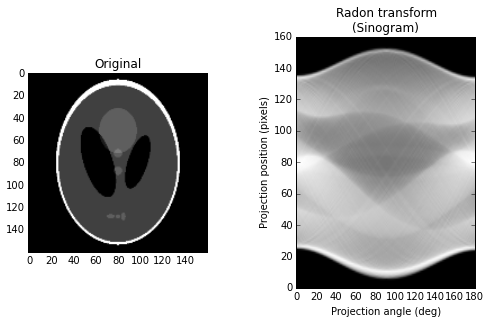

In [9]:

from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage import data_dir
from skimage.transform import radon, rescale

image = imread(data_dir + "/phantom.png", as_grey=True)
print(image.shape)

image = rescale(image, scale=0.4)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

theta = np.linspace(0., 180., max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta, circle=True)
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')

fig.subplots_adjust(hspace=0.4, wspace=0.5)
plt.show()



<div class="document" id="reconstruction-with-the-filtered-back-projection-fbp">
<h1 class="title">Reconstruction with the Filtered Back Projection (FBP)</h1>
<p>The mathematical foundation of the filtered back projection is the Fourier
slice theorem [2]. It uses Fourier transform of the projection and
interpolation in Fourier space to obtain the 2D Fourier transform of the image,
which is then inverted to form the reconstructed image. The filtered back
projection is among the fastest methods of performing the inverse Radon
transform. The only tunable parameter for the FBP is the filter, which is
applied to the Fourier transformed projections. It may be used to suppress
high frequency noise in the reconstruction. <tt class="docutils literal">skimage</tt> provides a few
different options for the filter.</p>
</div>


FBP rms reconstruction error: 0.0393


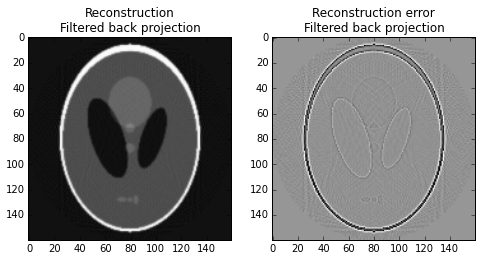

In [3]:

from skimage.transform import iradon

reconstruction_fbp = iradon(sinogram, theta=theta, circle=True)
error = reconstruction_fbp - image
print('FBP rms reconstruction error: %.3g' % np.sqrt(np.mean(error**2)))

imkwargs = dict(vmin=-0.2, vmax=0.2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))
ax1.set_title("Reconstruction\nFiltered back projection")
ax1.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction error\nFiltered back projection")
ax2.imshow(reconstruction_fbp - image, cmap=plt.cm.Greys_r, **imkwargs)
plt.show()



<div class="document" id="reconstruction-with-the-simultaneous-algebraic-reconstruction-technique">
<h1 class="title">Reconstruction with the Simultaneous Algebraic Reconstruction Technique</h1>
<p>Algebraic reconstruction techniques for tomography are based on a
straightforward idea: for a pixelated image the value of a single ray in a
particular projection is simply a sum of all the pixels the ray passes through
on its way through the object. This is a way of expressing the forward Radon
transform. The inverse Radon transform can then be formulated as a (large) set
of linear equations. As each ray passes through a small fraction of the pixels
in the image, this set of equations is sparse, allowing iterative solvers for
sparse linear systems to tackle the system of equations. One iterative method
has been particularly popular, namely Kaczmarz' method [3], which has the
property that the solution will approach a least-squares solution of the
equation set.</p>
<p>The combination of the formulation of the reconstruction problem as a set
of linear equations and an iterative solver makes algebraic techniques
relatively flexible, hence some forms of prior knowledge can be incorporated
with relative ease.</p>
<p><tt class="docutils literal">skimage</tt> provides one of the more popular variations of the algebraic
reconstruction techniques: the Simultaneous Algebraic Reconstruction Technique
(SART) [1] [4]. It uses Kaczmarz' method [3] as the iterative solver. A good
reconstruction is normally obtained in a single iteration, making the method
computationally effective. Running one or more extra iterations will normally
improve the reconstruction of sharp, high frequency features and reduce the
mean squared error at the expense of increased high frequency noise (the user
will need to decide on what number of iterations is best suited to the problem
at hand. The implementation in <tt class="docutils literal">skimage</tt> allows prior information of the
form of a lower and upper threshold on the reconstructed values to be supplied
to the reconstruction.</p>
</div>


SART (1 iteration) rms reconstruction error: 0.0461
SART (2 iterations) rms reconstruction error: 0.0348


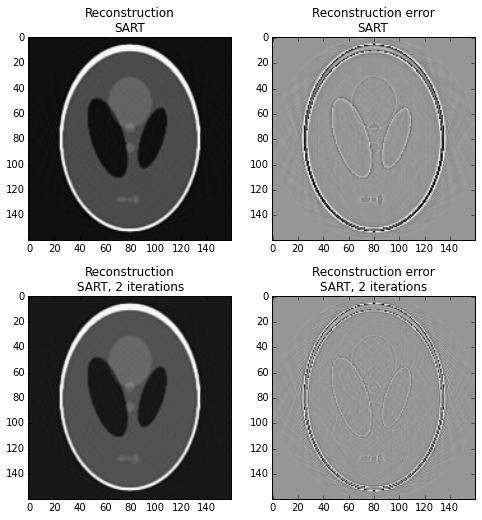

In [5]:

from skimage.transform import iradon_sart

reconstruction_sart = iradon_sart(sinogram, theta=theta)
error = reconstruction_sart - image
print('SART (1 iteration) rms reconstruction error: %.3g'
      % np.sqrt(np.mean(error**2)))

fig, ax = plt.subplots(2, 2, figsize=(8, 8.5))
ax1, ax2, ax3, ax4 = ax.ravel()
ax1.set_title("Reconstruction\nSART")
ax1.imshow(reconstruction_sart, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction error\nSART")
ax2.imshow(reconstruction_sart - image, cmap=plt.cm.Greys_r, **imkwargs)

# Run a second iteration of SART by supplying the reconstruction
# from the first iteration as an initial estimate
reconstruction_sart2 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart)
error = reconstruction_sart2 - image
print('SART (2 iterations) rms reconstruction error: %.3g'
      % np.sqrt(np.mean(error**2)))

ax3.set_title("Reconstruction\nSART, 2 iterations")
ax3.imshow(reconstruction_sart2, cmap=plt.cm.Greys_r)
ax4.set_title("Reconstruction error\nSART, 2 iterations")
ax4.imshow(reconstruction_sart2 - image, cmap=plt.cm.Greys_r, **imkwargs)
plt.show()



<div class="document">
<table class="docutils footnote" frame="void" id="id1" rules="none">
<colgroup><col class="label" /><col /></colgroup>
<tbody valign="top">
<tr><td class="label">[1]</td><td>AC Kak, M Slaney, &quot;Principles of Computerized Tomographic Imaging&quot;,
IEEE Press 1988. <a class="reference external" href="http://www.slaney.org/pct/pct-toc.html">http://www.slaney.org/pct/pct-toc.html</a></td></tr>
</tbody>
</table>
<table class="docutils footnote" frame="void" id="id2" rules="none">
<colgroup><col class="label" /><col /></colgroup>
<tbody valign="top">
<tr><td class="label">[2]</td><td>Wikipedia, Radon transform,
<a class="reference external" href="http://en.wikipedia.org/wiki/Radon_transform#Relationship_with_the_Fourier_transform">http://en.wikipedia.org/wiki/Radon_transform#Relationship_with_the_Fourier_transform</a></td></tr>
</tbody>
</table>
<table class="docutils footnote" frame="void" id="id3" rules="none">
<colgroup><col class="label" /><col /></colgroup>
<tbody valign="top">
<tr><td class="label">[3]</td><td>S Kaczmarz, &quot;Angenaeherte Aufloesung von Systemen linearer
Gleichungen&quot;, Bulletin International de l'Academie Polonaise des
Sciences et des Lettres 35 pp 355--357 (1937)</td></tr>
</tbody>
</table>
<table class="docutils footnote" frame="void" id="id4" rules="none">
<colgroup><col class="label" /><col /></colgroup>
<tbody valign="top">
<tr><td class="label">[4]</td><td>AH Andersen, AC Kak, &quot;Simultaneous algebraic reconstruction technique
(SART): a superior implementation of the ART algorithm&quot;, Ultrasonic
Imaging 6 pp 81--94 (1984)</td></tr>
</tbody>
</table>
</div>
